In [14]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as F1
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
from tqdm import tqdm
from torchvision.models import resnet101
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
class customDataset(Dataset):
    def __init__(self, videoList, classInd, subsample):
        with open(videoList) as f:
            self.videoList = f.read().splitlines()
        with open(classInd) as f:
            classList = f.read().splitlines()
            self.encodeClass = {x.split(" ")[1] : int(x.split(" ")[0]) - 1 for x in classList}
            self.decodeClass = {int(x.split(" ")[0]) -1 : x.split(" ")[1] for x in classList}
        self.subsample = subsample
        self.n = len(classList)

    def __len__(self):
        return len(self.videoList)

    def __getitem__(self, idx):
        videoPath = self.videoList[idx].split(" ")[0]
        label = self.encodeClass[videoPath.split("/")[0]]
        video, _, _ = torchvision.io.read_video("./UCF-101/"+videoPath, pts_unit='sec', output_format="TCHW")
        video = video[np.linspace(0, len(video)-1, self.subsample, dtype="int")]
        return video/255, label

In [7]:
class Net(nn.Module):
    def __init__(self, dropoutP):
        super().__init__()
        weights = torchvision.models.ResNet101_Weights.IMAGENET1K_V1
        self.resnet = resnet101(weights=weights)
        for parameter in self.resnet.parameters():
            parameter.requires_grad = False
        self.preprocess = weights.transforms()
        self.dropout = nn.Dropout(p=dropoutP)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, trainingData.n)

    def forward(self, xt):
        hidden = None
        for t in range(xt.size(1)):
            x = xt[:, t, :, :]
            x = self.preprocess(x)
            x = self.resnet(x)
            x, hidden = self.lstm(x.unsqueeze(0), hidden)
        x = self.dropout(x[-1, :, :])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
def accuracy(outputs, labels):
    with torch.no_grad():
        eq = outputs.argmax(1).to("cpu") == labels
        return (eq.sum() / eq.numel()).numpy()

In [4]:
params = {0 : [10, 0.1],
          1 : [9, 0.2],
          2 : [8, 0.3]}

In [9]:
history = []
for i in range(3):
    torch.cuda.empty_cache()
    subsample, dropoutP = params[i]

    trainingData = customDataset("customTrainList.txt", "classInd.txt", subsample)
    testData = customDataset("customTestList.txt", "classInd.txt", subsample)

    trainDataloader = DataLoader(trainingData, batch_size=12, shuffle=True, pin_memory=True)
    validationDataloader = DataLoader(testData, batch_size=12, shuffle=False, pin_memory=True)

    net = Net(dropoutP).to("cuda")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())


    lossTrainHist = []
    lossValidationHist = []
    accuracyTrainHist = []
    accuracyValidationHist = []
    minLoss = float('inf')

    for epoch in tqdm(range(40)):

        runningTrainLoss = 0.0
        runningValidationLoss = 0.0

        net.train()
        for i, data in enumerate(trainDataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = net(inputs.to("cuda"))

            lossTrain = criterion(outputs, labels.to("cuda"))
            lossTrain.backward()
            optimizer.step()

            runningTrainLoss += lossTrain.item()
            accuracyTrainHist.append(accuracy(outputs, labels))

        lossTrainHist.append(runningTrainLoss/(i+1))

        net.eval()
        for i, data in enumerate(validationDataloader, 0):
            inputs, labels = data
            with torch.no_grad():
                outputs = net(inputs.to("cuda"))

            lossValidation = criterion(outputs, labels.to("cuda"))

            runningValidationLoss += lossValidation.item()
            accuracyValidationHist.append(accuracy(outputs, labels))

        lossValidationHist.append(runningValidationLoss/(i+1))

        if minLoss>lossValidationHist[epoch]:
            minLoss = lossValidationHist[epoch]
            bestWeights = net.state_dict().copy()
            epochSave = epoch
    torch.save(bestWeights, str(i)+"w2.pth")
    history.append([lossTrainHist, lossValidationHist, accuracyTrainHist, accuracyValidationHist, minLoss, epochSave])

 22%|█████████████████▌                                                            | 9/40 [1:00:09<3:27:11, 401.00s/it]


KeyboardInterrupt: 

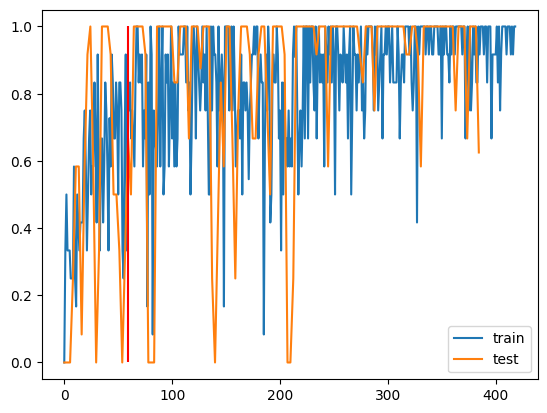

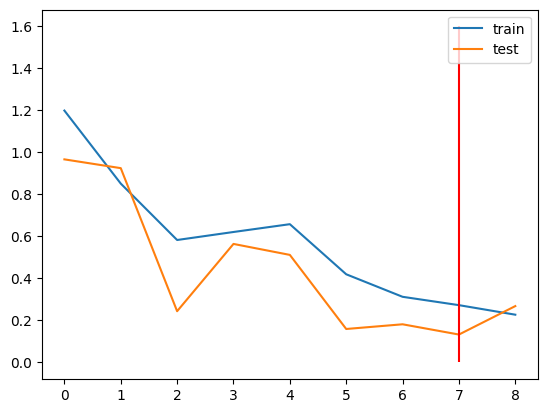

In [10]:
plt.plot(np.arange(len(accuracyTrainHist)),accuracyTrainHist)
plt.plot(np.arange(len(accuracyValidationHist))*2.6875,accuracyValidationHist)
plt.vlines(len(accuracyTrainHist)/50*epochSave,0,1, colors="red")
plt.legend(["train","test"])
plt.show()
plt.plot(range(len(lossTrainHist)),lossTrainHist)
plt.plot(range(len(lossValidationHist)),lossValidationHist)
plt.vlines(epochSave,0,1.6, colors="red")
plt.legend(["train","test"])
plt.show()

In [13]:
torch.cuda.empty_cache()
net = Net(0.1).to("cuda")
net.load_state_dict(torch.load("./15w2.pth"))
testDataset = customDataset("customTest4List.txt", "classInd.txt", 10)
testDataLoader = DataLoader(testDataset, batch_size=20, shuffle=False, pin_memory=True)

net.eval()
inputs, labels = next(iter(testDataLoader))
with torch.no_grad():
    outputs = net(inputs.to("cuda"))
accuracy(outputs, labels)

array(0.95, dtype=float32)

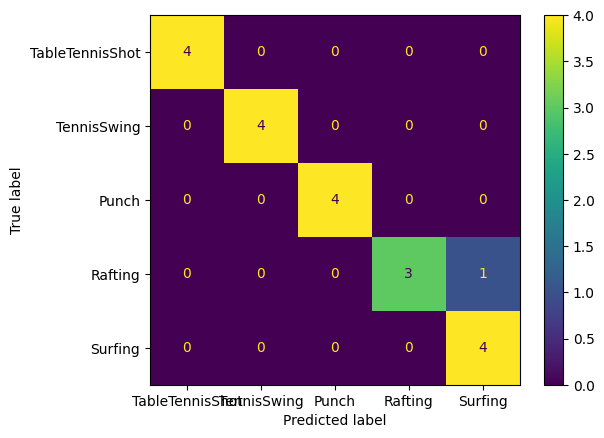

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(labels.cpu().numpy(),outputs.argmax(1).unsqueeze(1).cpu().numpy(),labels=list(range(5))),
                              display_labels=['TableTennisShot', 'TennisSwing', 'Punch', 'Rafting', 'Surfing'])

disp.plot()

plt.show()

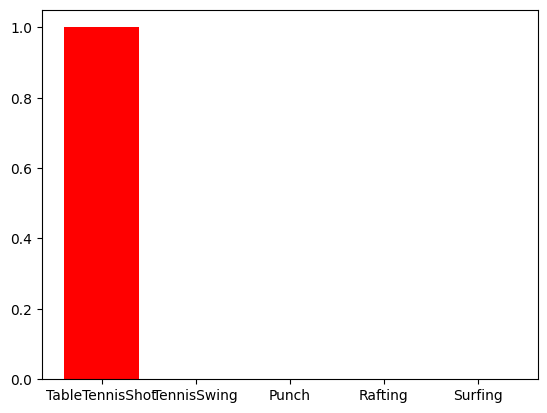

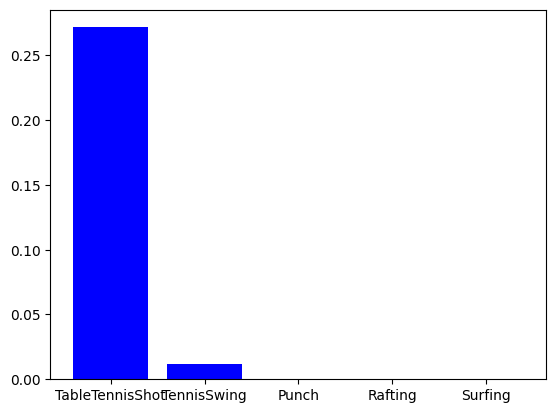

*********************************************************************************************


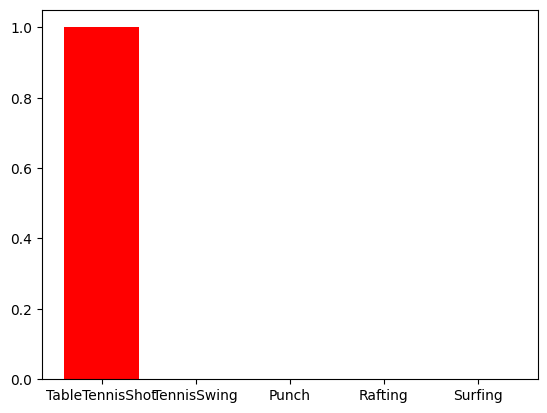

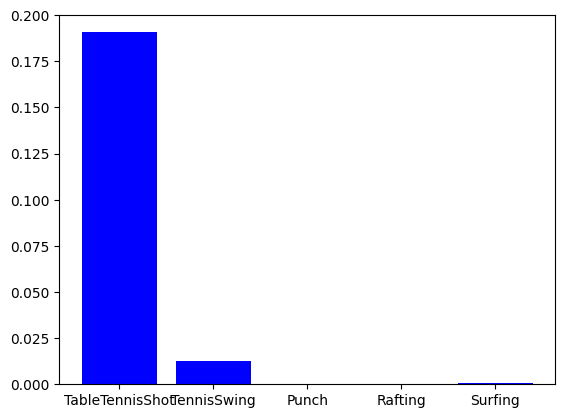

*********************************************************************************************


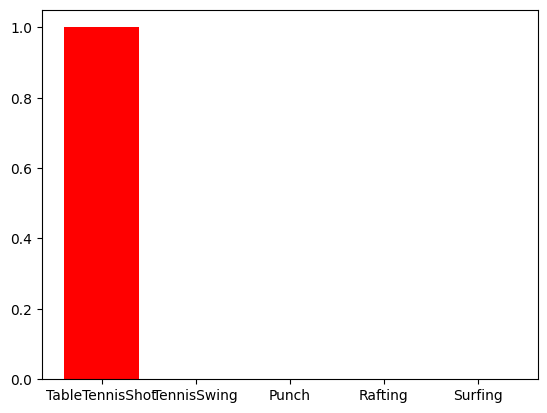

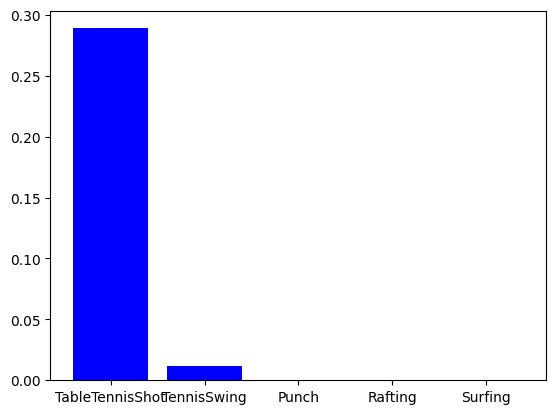

*********************************************************************************************


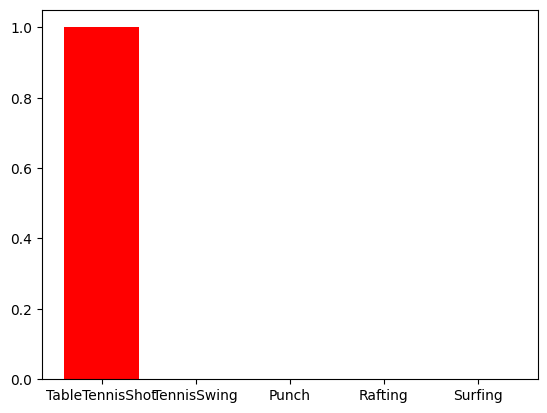

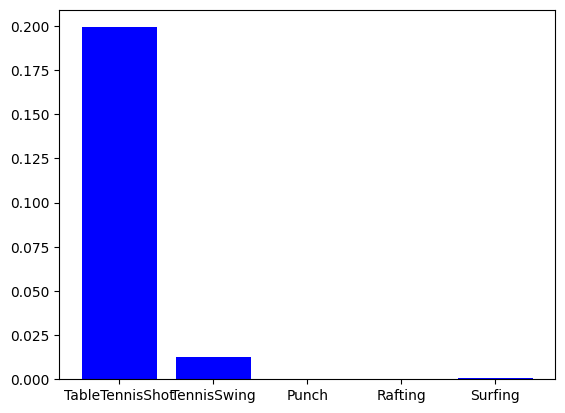

*********************************************************************************************


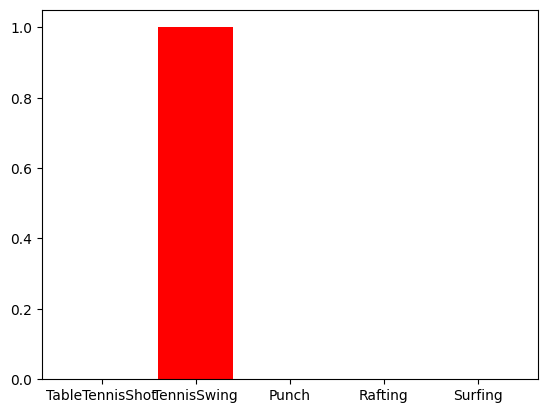

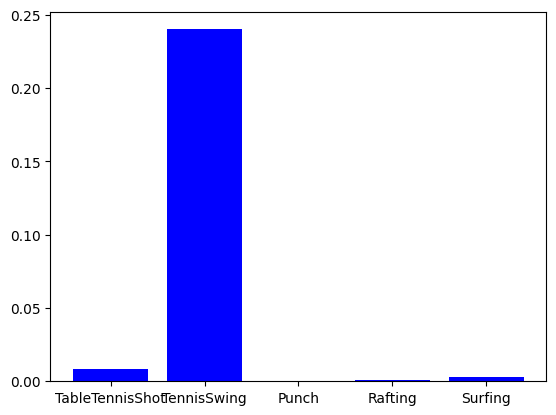

*********************************************************************************************


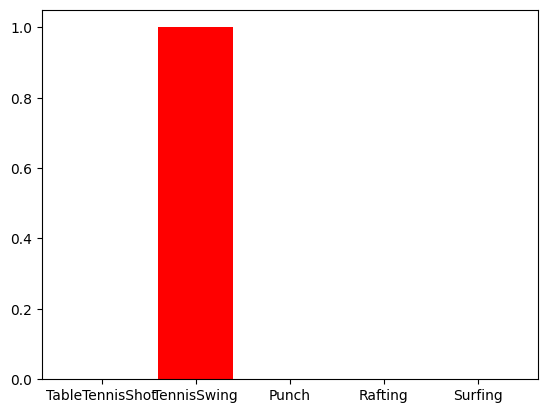

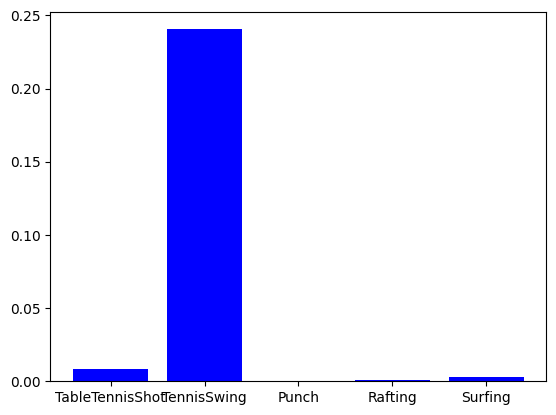

*********************************************************************************************


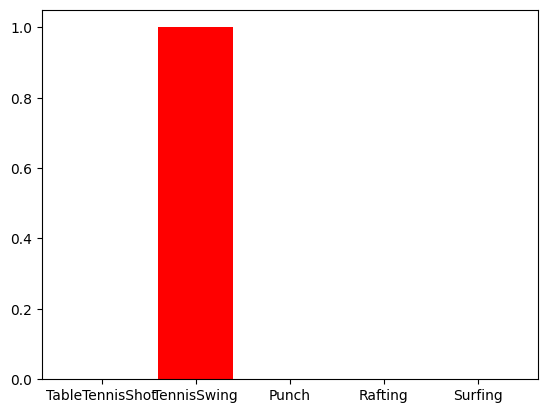

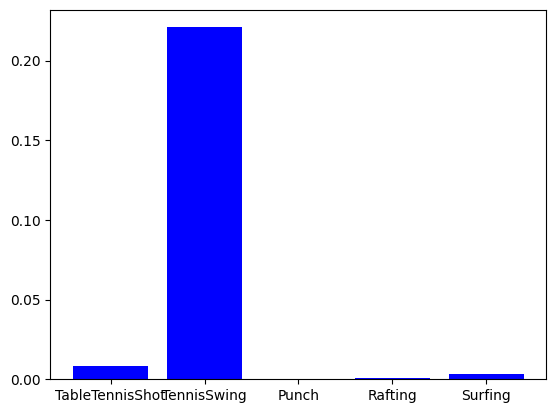

*********************************************************************************************


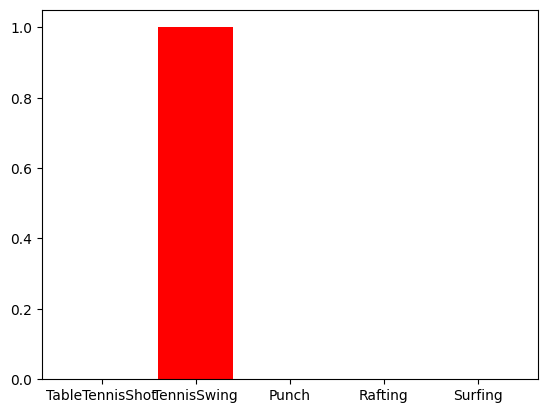

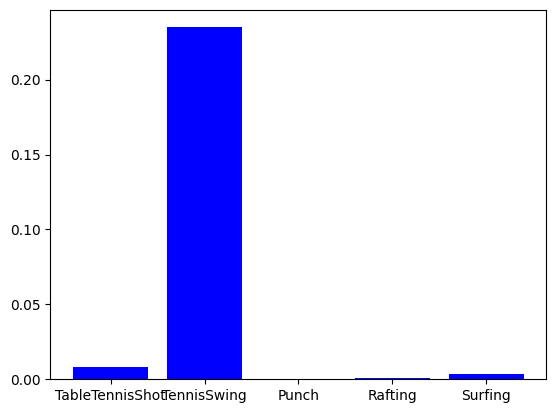

*********************************************************************************************


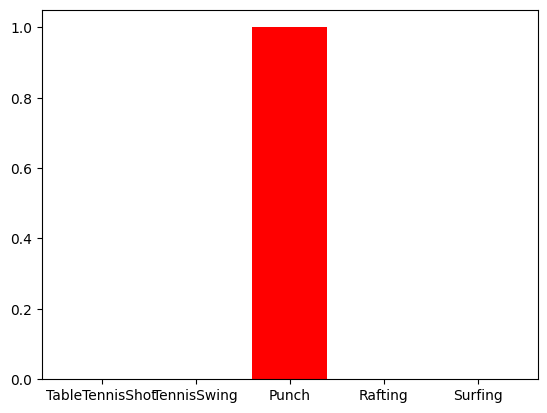

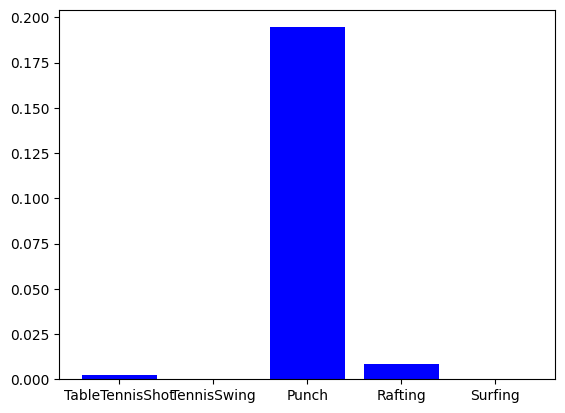

*********************************************************************************************


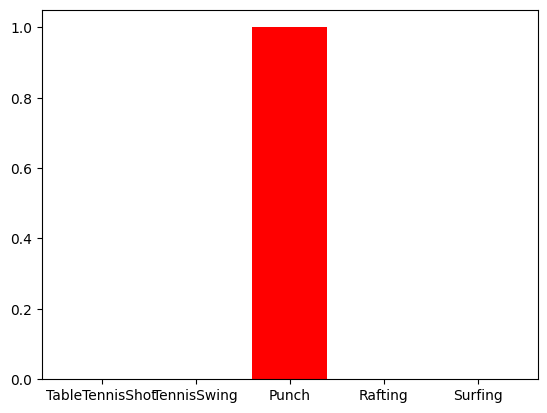

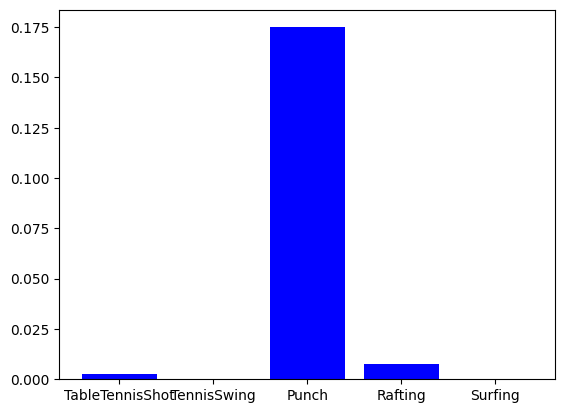

*********************************************************************************************


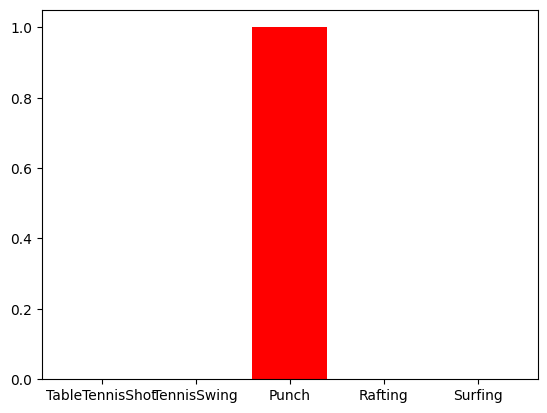

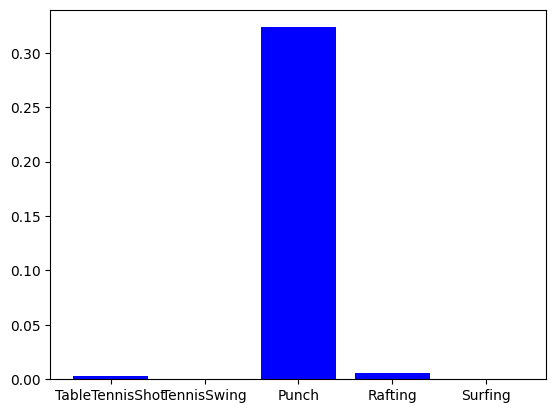

*********************************************************************************************


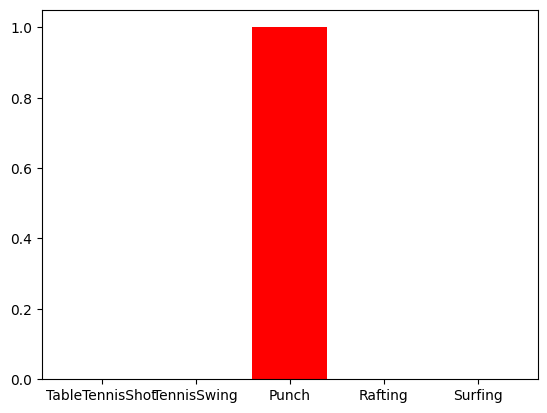

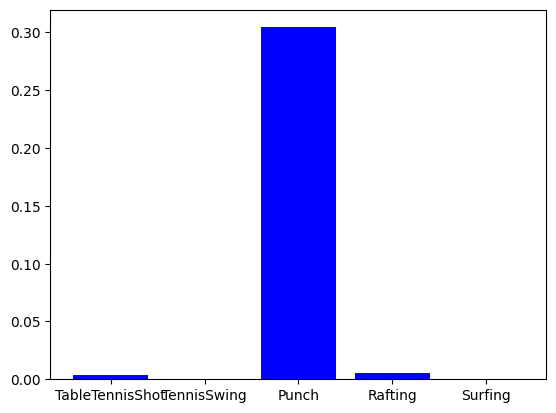

*********************************************************************************************


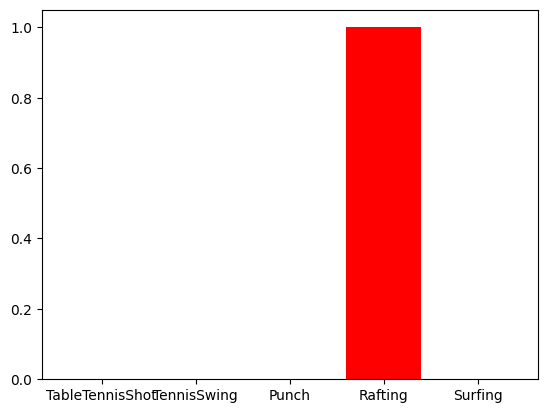

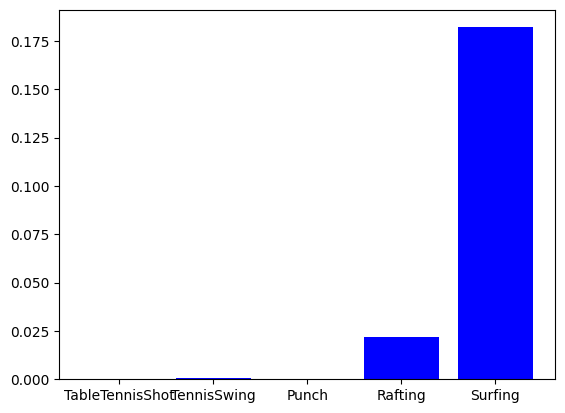

*********************************************************************************************


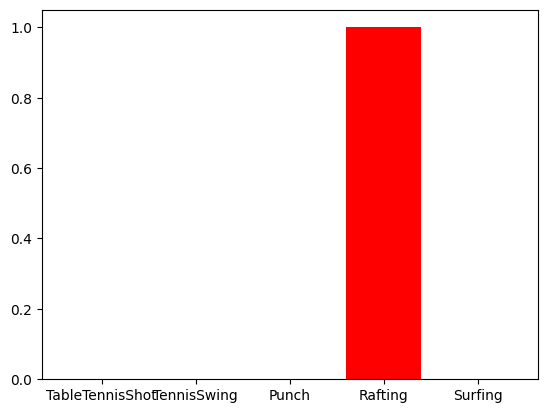

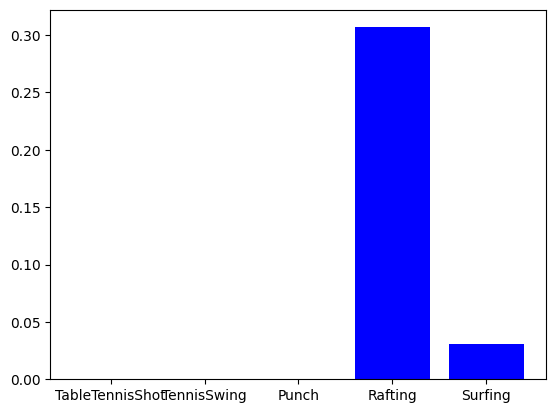

*********************************************************************************************


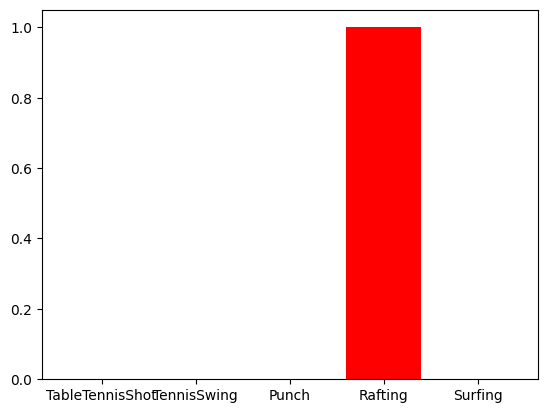

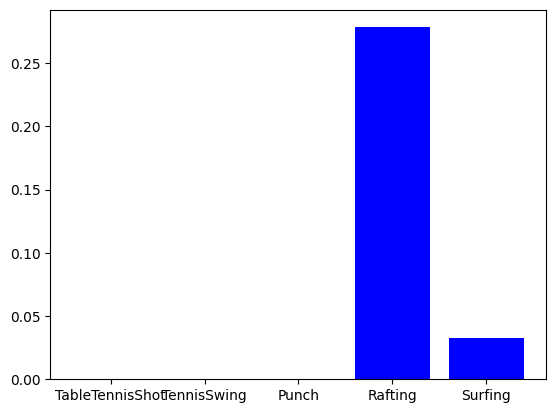

*********************************************************************************************


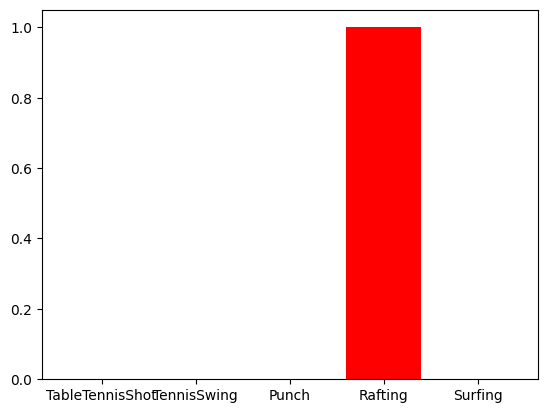

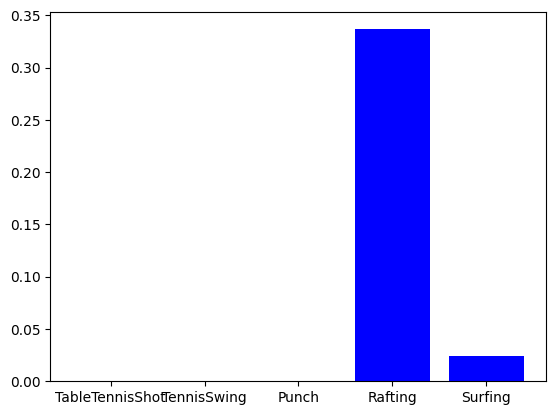

*********************************************************************************************


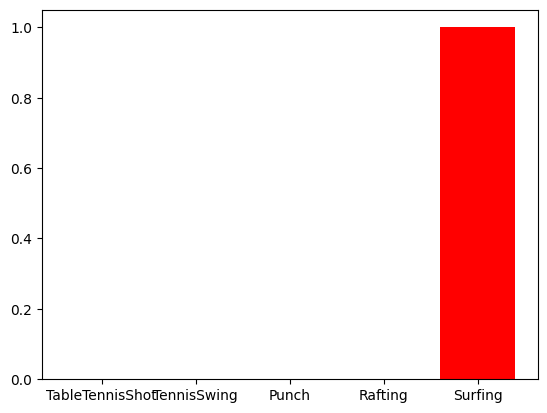

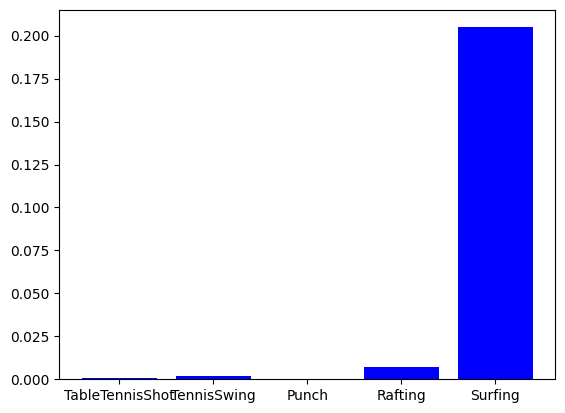

*********************************************************************************************


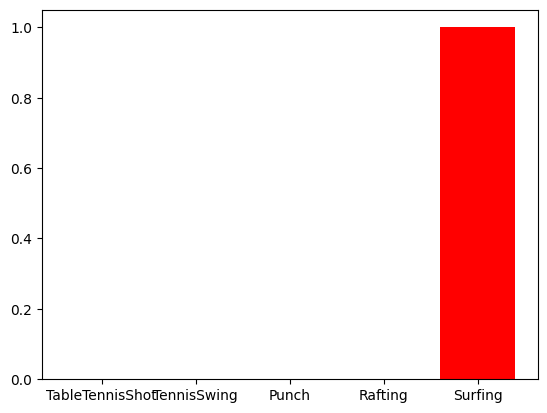

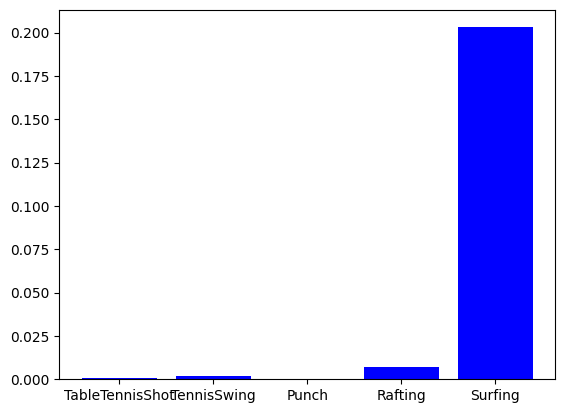

*********************************************************************************************


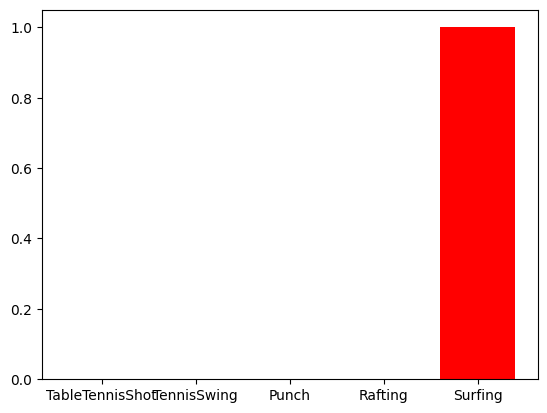

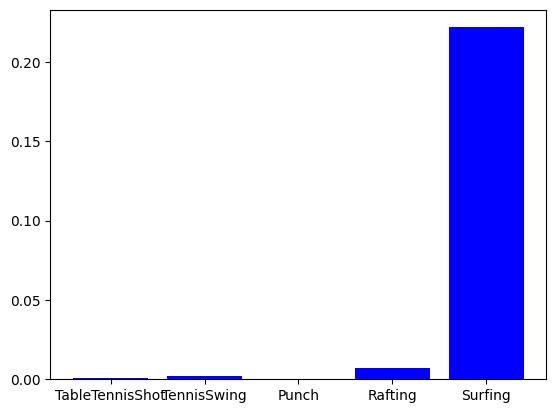

*********************************************************************************************


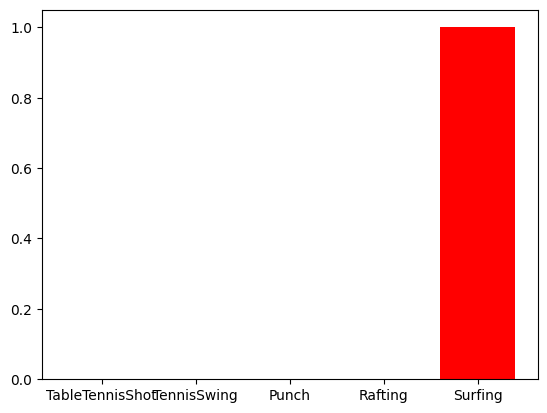

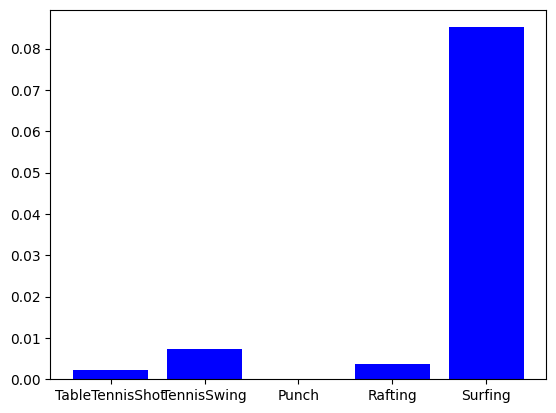

*********************************************************************************************


In [16]:
for i in range(20):
    trueLabel = np.zeros(5)
    trueLabel[labels[i]] = 1
    plt.bar(['TableTennisShot', 'TennisSwing', 'Punch', 'Rafting', 'Surfing'], trueLabel, color="red")
    plt.show()
    plt.bar(['TableTennisShot', 'TennisSwing', 'Punch', 'Rafting', 'Surfing'], outputs.softmax(0).cpu().numpy()[i], color="blue")
    plt.show()
    print("*********************************************************************************************")